# Gradient Calculations: "Dirtying" the Image

In [1]:
%run ./utility.ipynb

## Method two: Dirtying the Image
Here, we use a different method of computing gradients in order to speed up the gradient calculation process. By doing so, we should also see an increase in speed for the gradient descent.

First we start with the Gradient calculation. Consider the following loss term 

$$L_{data}(I) = \sum_a\frac{|I(u_a,v_a)-O_a|^2}{\sigma_a^2}$$

Here a represents which data point, O_a represents the data point itself, i and j are pixel coordinates, $I_{ij}$ is the image. By doing this, we get the gradient to be: 

$$G_{ij} = \frac{\partial L_{data}}{\partial I_{ij}} = \sum_a \frac{1}{\sigma_a^2}(\frac{\partial I(u_a,v_a)}{\partial I_{ij}}(I^*(u_a,v_a)-O_a^*) + (I(u_a,v_a)-O_a)\frac{\partial I^*(u_a,v_a)}{\partial I_{ij}})$$

Ideally we can compute the partial derivates as 

$$\frac{\partial I(u_a,v_a)}{\partial I_{ij}} = exp(\frac{2\pi i}{N}(iu_a+jv_a)), \frac{\partial I^*(u_a,v_a)}{\partial I_{ij}} = exp(-\frac{2\pi i}{N}(iu_a+jv_a))$$

N is the size of the image in pixels

We can further define things like so:

We introduce the so-called "dirty" image from observations as 

$$DO_{ij} = \sum_a \frac{1}{\sigma^2_a}\frac{\partial I^*(u_a,v_a)}{\partial I_{ij}}O_a$$


Here $I^*(u_a,v_a)$ is the fourier domain of the image at an observed data point.

We also define the "dirtying" of the image I as 

$$DI_{ij} = \sum_a \frac{1}{\sigma^2_a}\frac{\partial I^*(u_a,v_a)}{\partial I_{ij}}I(u_a,v_a)$$

This then gives us that 

$$G_{ij} = 2Re(DI_{ij}-DO_{ij})$$

In [2]:
sample = np.loadtxt("images/data.csv", delimiter=",")
coords, data_list = do_sample(25)
emp = np.zeros((80,80))

Here we preprocess and compute $\frac{\partial I(u_a,v_a)}{\partial I_{ij}}, \frac{\partial I^*(u_a,v_a)}{\partial I_{ij}}$

In [3]:
def preprocess_gradient(data_list, coords, image):
    """
    Precomputed the coefficients decribed in dirty gradient
    Args:
        data_list is a list of data objects
        coords is a list of u,v coordinates that we obtained from our data
        image is a 80x80 pixel image that represents our reconstructed image
    Returns:
        a 4d list of coefficients
    """
    r, c = np.shape(image)
    preprocessed = np.empty([r,c,len(data_list),2], dtype=np.complex_)
    for row in range(len(image)):
        for col in range(len(image[row])):
            for datum in range(len(data_list)):
                term = ((2*np.pi*1j)/image.size)*(row*coords[datum][0] + col*coords[datum][1]) #.size for numpy array returns # of rows * # of cols
                term_1 = np.exp(term)
                term_2 = np.exp(-1*term)
                preprocessed[row,col,datum,0] = term_1
                preprocessed[row,col,datum,1] = term_2
    return preprocessed

In [4]:
coeffs = preprocess_gradient(data_list, coords, emp)

Now, we can use the formula above to compute the gradient of the image directly

In [5]:
def dirty_gradient(data_list: list[data], coords, coeffs, image, FOV = 100*u.uas.to(u.rad)):
    """
    Calculates a gradient based on dirting the image
    Args:
        data_list is a list of data objects
        coords is a list of u,v coordinates that we obtained from our data
        coeffs is the precomputed coefficients
        image is a 80x80 pixel image that represents our reconstructed image
        FOV is the Field of view from the telescopes. For the EHT data, our FOV is 100 micro ascs.
    Returns:
        the gradient of the loss function
    """
    gradient_arr = np.empty(np.shape(image)) # Because we are in real space
    vis_images = interpolate(image, coords, FOV)
    for row in range(len(image)):
        for col in range(len(image[row])):
            gradient_sum = 0
            for i in range(len(data_list)):
                vis_data = data_list[i].vis_data
                vis_image = vis_images[i] # Ask about this on Wednesday
                term_1 = coeffs[row,col,i,0] * (np.conj(vis_image) - np.conj(vis_data))
                term_2 = coeffs[row,col,i,1] * (vis_image - vis_data)
                gradient_sum += (term_1 + term_2)/(data_list[i].sigma ** 2)
            gradient_arr[row,col] = gradient_sum.real
    return gradient_arr


# Why is it made of fourier harmonics
# Setting Visibilities of 1 for the purposes of this work

(-0.5, 79.5, 79.5, -0.5)

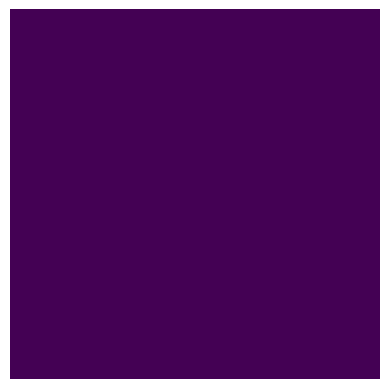

In [6]:
x = dirty_gradient(data_list, coords, coeffs, sample, FOV = 1)
plt.figure()
plt.imshow(x)
plt.axis('off')

Below is the gradient descent routine done in the fine gradient code

In [7]:
def gradient_descent(image, data_list, coords, coeffs = None, FOV = 100*u.uas.to(u.rad), stopper = None, dirty = False):
    """
    Performs gradient descent to reconstruct the image
    Args:
        image is a 80x80 pixel image that represents our reconstructed image
        data_list is a list of data objects
        coords is a list of u,v coordinates that we obtained from our data
        coeffs is the precomputed coefficients
        FOV is the Field of view from the telescopes. For the EHT data, our FOV is 100 micro ascs.
        stopper allows the descent to stop at 20 iterations
        dirty changes the gradient mode to dirty kernel
    Returns:
        the reconstructed image
    """
    image_copy = np.copy(image, subok=True) # Uses copy of the image due to lists being mutable in python
    i = 0
    grad = None
    # Can also use max here, min just makes it finish quicker
    while grad is None or np.min(np.abs(grad)) > 0.00001:
        t = 10000000 # Initial Step size which resets each iteration
        prev_loss = loss(image_copy, data_list, coords, FOV=FOV)

        if dirty:
            grad = dirty_gradient(data_list, coords, coeffs, image_copy)
        else:
            grad = gradient_finite_differences(data_list, coords, image_copy, FOV=FOV)

        new_image = image_copy - t * grad.real
        new_loss = loss(new_image, data_list, coords, FOV=FOV)
        
        while new_loss > prev_loss: # Only run when new_loss > prev_loss
            new_image = image_copy - t * grad.real
            new_loss = loss(new_image, data_list, coords, FOV=FOV)
            t /= 2

        image_copy -= t * 2 * grad.real # Multiply by 2 to undo last divide in the while loop
        i += 1
        if stopper != None:
            if i == stopper: # Hard stop here for notebook purposes
                return image_copy
        print("loss:",new_loss)
    return image_copy

(-0.5, 79.5, 79.5, -0.5)

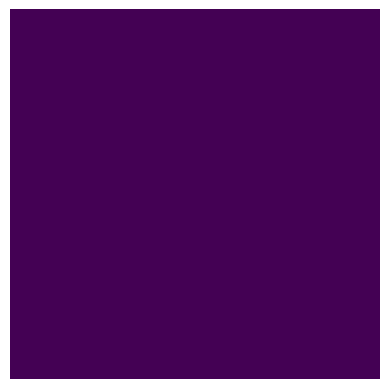

In [8]:
plt.figure()
plt.imshow(x)
plt.axis('off')

### Continuing Further

Now lets say that DFT (Discrete fourier transform) is defined as 


$$I(u,v) = \frac{1}{N}\sum^{N-1}_{i,j = 0} exp(-\frac{2\pi i}{N}(iu+jv))I_{ij}$$


$$I_{ij} = \frac{1}{N}\sum^{N-1}_{i,j = 0} exp(\frac{2\pi i}{N}(iu+jv))I(u,v)$$

The interpolation scheme computes $I(u_a,v_a)$ as $I(u_a,v_a) = \sum_{u,v = 0}^{N-1} W(u_a,v_a|u,v)I(u,v)$ where $W(u_a,v_a|u,v)$ stands for the weights of $u_a,v_a$ at u and v. The interpolation scheme will compute with only a few weights being non-zero for each a (assuming the interpolation is done in a local way). Putting this expression into $I(u,v)$ we get 

$$\frac{\partial I(u_a,v_a)}{\partial I_{ij}} = \frac{1}{N}\sum^{N-1}_{u,v = 0} W(u_a,v_a|u,v) exp(-\frac{2\pi i}{N}(iu+jv))$$

We this, we see that the partial derivative $\frac{\partial I(u_a,v_a)}{\partial I_{ij}}$ is the interpolation of the Fourier transform kernel.

Now, we can rewrite our formula for the Dirty Image.

$$DI(u,v) = \frac{1}{N}\sum_{i,j} exp(-\frac{2\pi i}{N}(iu+jv))DI_{ij}$$

$$ = \frac{1}{N}\sum_{i,j} exp(-\frac{2\pi i}{N}(iu+jv)) \sum_a \frac{1}{\sigma^2_a}\frac{\partial I^*(u_a,v_a)}{\partial I_{ij}}I(u_a,v_a)$$

$$ = \frac{1}{N}\sum_{i,j} exp(-\frac{2\pi i}{N}(iu+jv)) \sum_a \frac{1}{\sigma^2_a}\frac{1}{N}\sum^{N-1}_{u',v' = 0} W(u_a,v_a|u',v') exp(-\frac{2\pi i}{N}(iu'+jv'))I(u_a,v_a)$$

$$ = \sum_a \frac{1}{\sigma^2_a}W(u_a,v_a|u,v)I(u_a,v_a) $$

$$ = \sum_a \frac{1}{\sigma^2_a}W(u_a,v_a|u,v)\sum^{N-1}_{u',v' = 0} W(u_a,v_a|u',v')I(u',v')$$

Now lets finally introduce the "dirty kernel" DK.

$$DK(u,v|u',v') = \sum_a \frac{1}{\sigma^2_a}W(u_a,v_a|u,v)W(u_a,v_a|u',v')$$

This transforms the dirty image equation to be 

$$DI(u,v) = \sum^{N-1}_{u',v' = 0} DK(u,v|u',v') I(u',v')$$

Notice here that for each $(u,v)$ there are only a few points $(u',v')$ close by where $DK(u,v|u',v') \neq 0$. Thus for each point $(u,v)$ in the Fourier domain, we can create a small list of $(u',v')$ points with tabulated $DK$ values.

Another important note is that we can dirty the image quickly since the dirty kernel is able to be precomputed. We can do so since it only depends on observational data. The time complexity of going from the image to the fourier domain using DFT is about $O(N^2lnN)$ whereas the time complexity of going from image to dirty image by using the dirty kernel method is about $O(N^2)$. 

The code below was written by Misha Stepanov in order to quickly calculate DI, DO, and DK.

In [9]:
import numpy as np
N = 80;  coeff = 4.84813681109536e-10;  Breg = 10000.;  Nreg = 100.

# reading data
list_of_strings = []
with open('./data/SR1_M87_2017_095_hi_hops_netcal_StokesI.csv', 'r') as f:
  for line in f:
    list_of_strings.append(line)
list_of_strings.pop(0)
Na = len(list_of_strings)
print(len(list_of_strings))
UVa, sigma = np.zeros((2*Na, 2)), np.zeros(2*Na)
Oa = np.zeros(2*Na).astype(complex)
for a in range(Na):
  current_string = (list_of_strings[-1]).split(",") # Split on commas
  list_of_strings.pop()
  UVa[a, 0], UVa[a, 1] = float(current_string[3]), float(current_string[4])
  Oa[a] = float(current_string[5])*np.exp(1j*float(current_string[6])*np.pi/180.)
  sigma[a] = float(current_string[7])
  UVa[a + Na], Oa[a + Na], sigma[a + Na] = -UVa[a], np.conj(Oa[a]), sigma[a]
del list_of_strings, current_string

# local cubic interpolation
def cubf1(x, y):                              #      8  11
  cf1 = (1. + x - x*x)*(1. + 2.*y)*(1. - y)   #   8  2  3  10
  cf2 = (1. + y - y*y)*(1. + 2.*x)*(1. - x)   #   4  0  1  6
  return 0.5*(cf1 + cf2)*(1. - x)*(1. - y)    #      5  7
def cubf2(x, y):  return -0.5*x*(1. - x)*(1. - x)*(1. + 2.*y)*(1. - y)*(1. - y)
IND = np.array([[-2, -2], [-1, -2], [-2, -1], [-1, -1], [-3, -2], [-2, -3], \
  [0, -2], [-1, -3], [-3, -1], [-2, 0], [0, -1], [-1, 0]]).astype(int)
def cubfun12(x, y):  return np.array([cubf1(x, y), cubf1(1. - x, y), \
    cubf1(x, 1. - y), cubf1(1. - x, 1. - y), cubf2(x, y), cubf2(y, x), \
    cubf2(1. - x, y), cubf2(y, 1. - x), cubf2(x, 1. - y), cubf2(1. - y, x), \
    cubf2(1. - x, 1. - y), cubf2(1. - y, 1. - x)])

"""
Calculate DO
Compare G = -2DO
"""

# computing DO, the dirty image from observations
DOuv = np.zeros((N, N)).astype(complex)
for a in range(2*Na):
  m = np.mod(coeff*UVa[a], N);  x, y = m - np.floor(m)
  m1, m2 = np.floor(np.mod(m + np.array([2., 2.]), N)).astype(int)
  C, CUBFUN = Oa[a] / sigma[a]**2, cubfun12(x, y)
  for c in range(12):  DOuv[m1 + IND[c, 0], m2 + IND[c, 1]] += C*CUBFUN[c]
DO = N*np.real(np.fft.ifft2(DOuv))
del DOuv

# computing DK, the dirty kernel
DK49, DK = np.zeros((N, N, 7, 7)), []
for a in range(2*Na):
  m = np.mod(coeff*UVa[a], N);  x, y = m - np.floor(m)
  m1, m2 = np.floor(np.mod(m + np.array([2., 2.]), N)).astype(int)
  C, CUBFUN = 1. / sigma[a]**2, cubfun12(x, y)
  for c in range(12):
    for cp in range(12):
      DK49[m1 + IND[c, 0], m2 + IND[c, 1], 3 + IND[cp, 0] - IND[c, 0], \
           3 + IND[cp, 1] - IND[c, 1]] += CUBFUN[c]*CUBFUN[cp]*C
for u in range(N):
  for v in range(N):
    for du in range(7):
      for dv in range(7):
        if (DK49[u, v, du, dv] != 0.):
          DK.append([u, v, ((u + du) % N) - 3, ((v + dv) % N) - 3, \
            DK49[u, v, du, dv]])
del DK49, IND, CUBFUN

# computing DI, the dirtying of the image I
I12, Iuv = np.zeros((2, N, N)), np.zeros((N, N)).astype(complex)
DI, DIuv = np.zeros((N, N)), np.zeros((N, N)).astype(complex)
def calc_DI():
  global Iuv, DI, DIuv
  Iuv, DIuv = np.fft.fft2(I), np.zeros((N, N)).astype(complex)
  for q in DK:  DIuv[q[0], q[1]] += q[4]*Iuv[q[2], q[3]]
  DI = np.real(np.fft.ifft2(DIuv))
  return

# computing G, the gradient of the loss function
def neighbor(Iat, Inear):  return np.sign(Iat - Inear)
def calc_G():
  global G
  calc_DI()
  G = 2.*(DI - DO)
  for i in range(N):
    for j in range(N):
      if (I[i, j] < 0.):  G[i, j] -= Breg
      if (I[i, j] > 0.):  G[i, j] += Nreg
  return

I, dt = (0.*DO), 0.00001

calc_DI()

6458


Below is what the gradient looks like after running the dirty kernel code. What is remarkable is its similarity to the gradient calculated in the finite differences notebook in a fraction of the time. I am using a 2021 MacBook Pro with an M1 chip and the dirty kernel code took 2.5 seconds while the finite differences code took 34.4 seconds.

Text(0.5, 1.0, 'coeff = FOV')

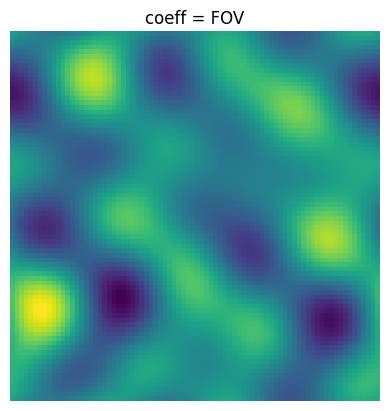

In [10]:
plt.figure()
plt.imshow(-2*DO)
plt.axis('off')
plt.title("coeff = FOV")